(page:echem_phase_diagram)=
# Electrochemical Phase Diagrams

This script generates an electrochemical phase diagram from a set of oxidized structures using the Extended Ab-Initio Thermodynamics (EAITD) approach: [T. Jacob, J. Electroanal. Chem. 2007, 607, 158–166](https://www.sciencedirect.com/science/article/abs/pii/S0022072807001611).
The EAITD approach assumes conditions under which the standard hydrogen electrode (SHE) is defined: T = 298.15 K, p = 1 bar, pH 0. In this context, the standard hydrogen electrode is also often referred to as the computational hydrogen electrode, CHE. Thermochemical ($H - H_0$) and entropic ($T\ \Delta S$) corrections are obtained from the [NIST-JANAF thermochemical tables](https://janaf.nist.gov/).

Similar to the [adsorption isobar analysis](page:adsorption_isobar), the oxygen coverage is calculated by means of the O/Pt ratio, $x_\mathrm{O} = \frac{n_\mathrm{O}}{n_\mathrm{Pt}}$. The script first calculates the energy of formation of each structure according to $\Delta E_\mathrm{F} = E_\mathrm{structure} - E_\mathrm{ref} - n_\mathrm{O} (\mu_\mathrm{H_2O} - \mu_\mathrm{H_2})$. $\mu_\mathrm{H_2O}$ and $\mu_\mathrm{H_2}$ are the chemical potential of $\mathrm{H_2O}$ and $\mathrm{H_2}$ at SHE conditions, respectively. We thereby implicitly assume that all oxygen atoms in the oxidized particles originate from the water splitting reaction. The script then finds the structure with the most favorable $\Delta E_\mathrm{F}$ for each coverage, for which we chose discretized coverage bins of width $\Delta x_\mathrm{O} = 0.1$.

Under SHE conditions, the following reaction is assumed to be in equilibrium: $\mathrm{H_2} \leftrightarrow 2 H^+ + 2 e^-$. We can therefore find the potential-dependent formation energy as $\Delta E_\mathrm{F}(\Delta \phi) = E_\mathrm{structure} - E_\mathrm{ref} - n_\mathrm{O} (\mu_\mathrm{H2O} - 2 \mu_\mathrm{H+} - 2 e \Delta \phi)$. This re-referencing allows us to calculate the formation energy as a function of the potential.

To construct the electrochemical phase diagram, the code below evaluates the entire data set of *ca.* 90,000 structures. Unlike for the [adsorption isobar analysis](page:adsorption_isobar), this code "forgets" the original $T$ and $p$ conditions under which the structures were generated: for this analysis, $\Delta E_\mathrm{F}$ is not calculated based on the original $\mu_\mathrm{O}$ but are re-referenced with respect to $\mathrm{H_2O}$ and $\mathrm{H_2}$ under the assumption of SHE conditions and the water splitting reaction. The original conditions for the ReaxFF-GCMC simulations are, however, not irrelevant: the GCMC algorithm generates the highest density of output structures around the thermodynamic equilibrium conditions as set by $\mu_\mathrm{O}$, which can be related back to a combination of $T$ and $p$. Therefore, by ensuring that a broad range of $T$ and $p$ are screened in ReaxFF-GCMC simulations, we ensure that the configuration space is properly sampled at each coverage $x_\mathrm{O}$, which will in turn greatly improve the quality of output of this particular analysis.

Similar to the approach in case of the [adsorption isobar analysis](page:adsorption_isobar), the entire data set will be analyzed in the following. Start by reading it in.

In [1]:
import pandas as pd

data = pd.read_csv("../data/data.csv")

Before we start to calculate the formation energy, pre-define some constants that we need below. The ReaxFF total energy values were generated using a modified version of the [force field from D. Fantauzzi, et al., Phys. Chem. Chem. Phys. 2014, 16, 23118–23133](https://pubs.rsc.org/en/content/articlelanding/2014/cp/c4cp03111c) which has additional parameters for Pt-H and O-H interactions. The force field is available upon reasonable request from Prof. Dr. Timo Jacob (Institute of Electrochemistry, Ulm University, Germany).

In [2]:
kcal2ev = 23.06035             # Convert kcal mol-1 to eV.
Eref = -59782.464426 / kcal2ev # ReaxFF otal energy value for clean octahedral nanoparticle.
n_Pt = 489                     # Number of Pt atoms in clean octahedral nanoparticle.
EH2O = -249.21 / kcal2ev       # ReaxFF total energy for H2O.
muH2O = EH2O - 0.484142275     # EH2O + (H - H0) - T Delta S (from NIST-JANAF tables).
EH2 = -108.721028 / kcal2ev    # ReaxFF total energy for H2.
muH2 = EH2 - 0.318221265       # EH2 + (H - H0) - T Delta S (from NIST-JANAF tables).

The goal is to build a results `dictionary` that contains the structure with the lowest $\Delta E_\mathrm{F}$ for each coverage, as indicated by the O:Pt ratio $x_\mathrm{O}$. We will consider $x_\mathrm{O}$ binwidths of 0.1 to differentiate degrees of oxidation.

Loop through the entire data set, calculate $x_\mathrm{O}$ and $\Delta E_\mathrm{F}$ and overwrite the `bestStructure` results array whenever a structure with lower $\Delta E_\mathrm{F}$.

In [3]:
bestStructures = {}
for index, structure in data.iterrows():
    
    # Calculate coverage.
    n_O = structure["n_O"]
    xO = n_O / n_Pt
    xOString = "{:.1f}".format(xO)

    # Calculate formation energy.
    Eform = structure["Etot"] / kcal2ev - Eref - n_O * (muH2O - muH2)

    # Check of this structure with coverage xO has lower Eform
    # as previous best structure on bestStructures dict.
    if xOString in bestStructures:
        if Eform < bestStructures[xOString][0]:
            bestStructures[xOString] = [Eform, n_O]
    else:
        bestStructures.update({xOString: [Eform, n_O]})

The `bestStructures` results dictionary has the form {$x_\mathrm{O}$: \[$\Delta E_\mathrm{F}$ , # of O atoms\]}.

In [4]:
print(bestStructures)

{'0.2': [139.56269248552428, 74], '0.1': [39.03799925299637, 25], '0.0': [-0.002591027456219308, 0], '0.3': [235.5470629996198, 123], '1.4': [1552.2665685088155, 661], '1.2': [1279.2382707523007, 563], '0.6': [603.1294559030753, 269], '1.3': [1403.0527900715965, 612], '0.9': [943.677299615516, 416], '1.1': [1144.4986916659159, 514], '0.7': [718.5795839620482, 318], '0.8': [830.4102361240798, 367], '0.5': [482.8770574346322, 221], '1.0': [1051.0556385646096, 465], '0.4': [346.13011761868324, 172], '1.5': [1709.848466250381, 710]}


All that's left to do is to visualize the structures as a function of the cell potential $\phi$.

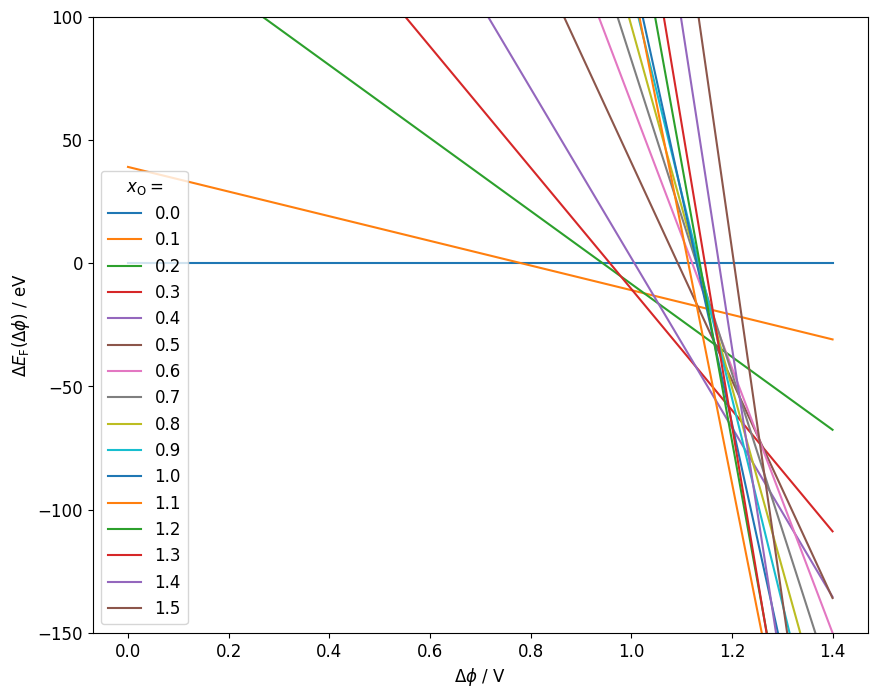

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 12})

for xOString, (Eform, n_O) in sorted(bestStructures.items()):
    x = []
    y = []
    for phi in range(0, 15, 1):
        phi /= 10
        EformPhi = Eform - n_O * 2 * phi
        x.append(phi)
        y.append(EformPhi)
    plt.plot(x, y, label=xOString)

plt.xlabel("$\Delta \phi$ / V")
plt.ylabel("$\Delta E_{\mathrm{F}}(\Delta \phi)$ / eV")
plt.ylim(-150, 100)
plt.legend(title="$x_\mathrm{O} = $")
plt.show()

The output shows the potential-dependent formation energy for the lowest-energy structures for each coverage bin. However, it is evident that some coverages are more stable than others. Next steps to improve the data visualization may include filtering the output structures to only show the enveloping, lowest energy structures as done in [J. Phys. Chem. C 2022, 126, 6773–6781](https://pubs.acs.org/doi/full/10.1021/acs.jpcc.2c00472) and [Small 2020, 16, 1905159](https://onlinelibrary.wiley.com/doi/full/10.1002/smll.201905159).